# Song Information Grabber

The goal is to grab information of the song that could possibly help the Neural Network with weights and etc...

By: 
- Andrew Angulo
- Daniel Ziabicki
- Liam Quinlan

In [ ]:
import os
import pandas as pd
import numpy as np
#import scipy.io
import matplotlib.pyplot as plt

# from scipy.io import wavfile
from os.path import dirname, join as pjoin

---
# Grabbing The Song

In [57]:
# Get the current working directory (where your notebook/script is running)
current_dir = os.getcwd()

# Build the path to the Test_Songs folder
data_dir = pjoin(current_dir, 'Test_Songs')

# Full path to the song
song_path = pjoin(data_dir, 'Lifestyle.wav')

---
# Understanding the data within the Song file

Utilizing the documentation to understand the data from the example song file

[Librosa Documentation](https://librosa.org/doc/latest/index.html)

In [ ]:
%pip install librosa

In [24]:
import librosa

In [58]:
audio_data, sample_rate = librosa.load(song_path)

y, sr = librosa.load(song_path, duration=10)


In [60]:
tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
print(f"Tempo: {tempo}")
print(f"Beats: {beats}")

Tempo: [69.83741554]
Beats: [  3  37  71 103 135 172 208 248 292 329 363 400]


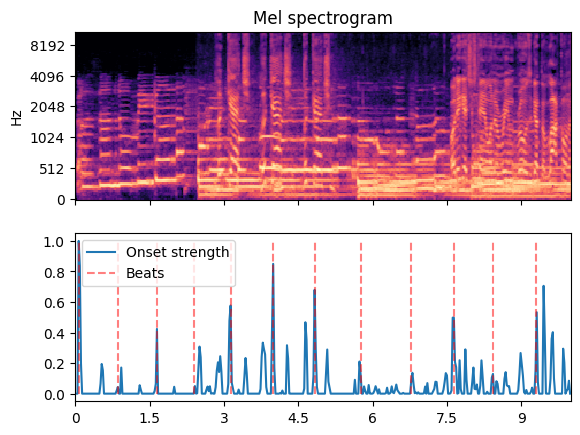

In [61]:
hop_length = 512
onset_env = librosa.onset.onset_strength(y=y, sr=sr, aggregate=np.median)
fig, ax = plt.subplots(nrows=2, sharex=True)
times = librosa.times_like(onset_env, sr=sr, hop_length=hop_length)
M = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hop_length)
librosa.display.specshow(librosa.power_to_db(M, ref=np.max), y_axis='mel', x_axis='time', hop_length=hop_length, ax=ax[0])

ax[0].label_outer()
ax[0].set(title='Mel spectrogram')
ax[1].plot(times, librosa.util.normalize(onset_env), label='Onset strength')
ax[1].vlines(times[beats], 0, 1, alpha=0.5, color='r', linestyle='--', label='Beats')
ax[1].legend()